In [2]:
#Load and merge data
import pandas as pd
file_demo = 'Patient_Demo.csv'
file_visit = 'Patient_Hospital_Visit.csv'
df_patient_demo = pd.read_csv(file_demo)
df_hospital_visit = pd.read_csv(file_visit)

###############################
# Convert date columns to datetime
df_hospital_visit['inserted_at'] = pd.to_datetime(df_hospital_visit['inserted_at'])
df_patient_demo['dob'] = pd.to_datetime(df_patient_demo['dob'])

###########################################
# Ensure state names are capitalized
df_patient_demo['state'] = df_patient_demo['state'].str.title()
# Merge data on 'patient_id' and 'institution_id'
df_merged = pd.merge(df_hospital_visit, df_patient_demo, on=['patient_id', 'institution_id'], how='left')

##################################################
# Calculate age from dob and inserted_at
df_merged['age'] = (df_merged['inserted_at'] - df_merged['dob']).dt.days // 365

In [3]:
df_merged.isnull().sum()

visit_id               0
patient_id             0
institution_id         0
admitted_at       430618
discharged_at     430518
inserted_at            0
updated_at             0
visit_type             0
type                   0
dob                  660
sex                  745
state             115070
age                  660
dtype: int64

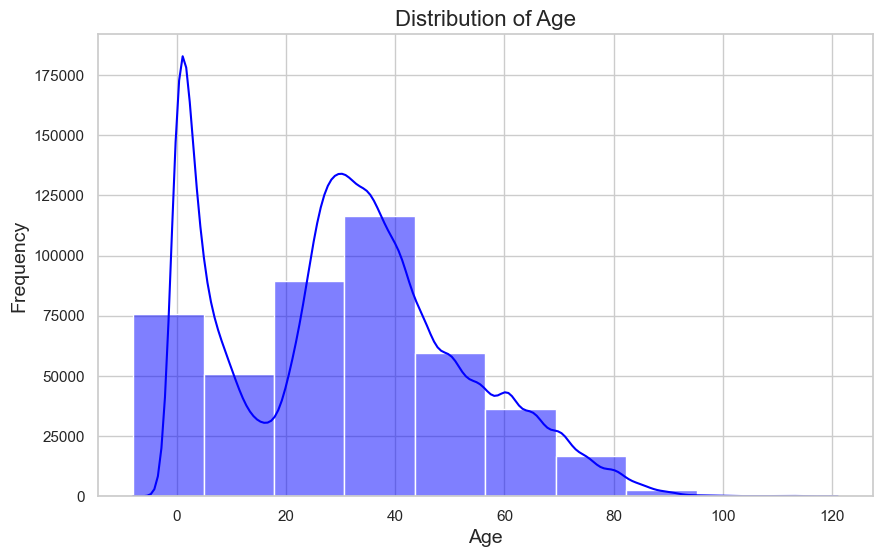

In [ ]:
#Visualize distribution of columns with missing values
import seaborn as sns
import matplotlib.pyplot as plt
# Plot the distribution
sns.set(style="whitegrid")  # Set style
plt.figure(figsize=(10, 6))  # Set figure size
sns.histplot(df_merged['age'], kde=True, bins=10, color='blue')  # Histogram with KDE
plt.title('Distribution of Age', fontsize=16)  # Add title
plt.xlabel('Age', fontsize=14)  # Add x-axis label
plt.ylabel('Frequency', fontsize=14)  # Add y-axis label
plt.show()

In [7]:
#Since the plot above is left skewed, we can fill in the missing values in age column with the median.

# Fill missing values with the median of the column
median_value = df_merged["age"].median()
df_merged["age"].fillna(median_value, inplace=True)

#We can fill in the sex column with the mode.

# Calculate the mode (most frequent value)
mode_value = df_merged['sex'].mode()[0]  # Access the first mode in case of multiple modes

# Fill missing values with the mode
df_merged['sex'].fillna(mode_value, inplace=True)

df_merged.isnull().sum()


visit_id               0
patient_id             0
institution_id         0
admitted_at       430618
discharged_at     430518
inserted_at            0
updated_at             0
visit_type             0
type                   0
dob                  660
sex                    0
state             115070
age                    0
dtype: int64

In [9]:
'''The missing values in state is too high the replace with mode, 
also the number of values in state to select just one value to fill
in the missing values.
Best course of action is to drop the missing values.'''
df_merged.dropna(inplace=True)
df_merged.isnull().sum()

visit_id          0
patient_id        0
institution_id    0
admitted_at       0
discharged_at     0
inserted_at       0
updated_at        0
visit_type        0
type              0
dob               0
sex               0
state             0
age               0
dtype: int64

In [10]:
###############################################
# Aggregate visit data by date and institution_id
visit_data = (
    df_merged.groupby(['inserted_at', 'institution_id'])
    .size()
    .reset_index(name='visit_count')
)

########################################################
# Calculate the unique count of patients (volume) per institution
patient_count_per_institution = (
    df_merged.groupby('institution_id')['patient_id']
    .nunique()
    .reset_index(name='patient_count')
)

#############################################################
# Calculate the number of unique states each institution is present in
states_per_institution = (
    df_merged.groupby('institution_id')['state']
    .nunique()
    .reset_index(name='state_count')
)

##########################################################
# Calculate the average age per institution
avg_age_per_institution = (
    df_merged.groupby('institution_id')['age']
    .mean()
    .reset_index(name='avg_age')
)

#############################################################
# Calculate the total visit count per institution
total_visits_per_institution = (
    df_merged.groupby('institution_id')
    .size()
    .reset_index(name='total_visit_count')
)

#######################################################
# Merge all features into one dataframe
institution_features = pd.merge(total_visits_per_institution, patient_count_per_institution, on='institution_id', how='left')
institution_features = pd.merge(institution_features, avg_age_per_institution, on='institution_id', how='left')
institution_features = pd.merge(institution_features, states_per_institution, on='institution_id', how='left')

########################################################
# Merge patient count, state count, and average age into visit_data
visit_data = pd.merge(visit_data, patient_count_per_institution, on='institution_id', how='left')
visit_data = pd.merge(visit_data, states_per_institution, on='institution_id', how='left')
visit_data = pd.merge(visit_data, avg_age_per_institution, on='institution_id', how='left')

###############################################################
# Feature Engineering: Create lag features, rolling averages, and other time-based features
def create_features(df):
    df['day_of_week'] = df['inserted_at'].dt.dayofweek
    df['month'] = df['inserted_at'].dt.month
    df['day_of_year'] = df['inserted_at'].dt.dayofyear
    df['lag_1'] = df['visit_count'].shift(1)
    df['lag_7'] = df['visit_count'].shift(7)
    df['rolling_mean_7'] = df['visit_count'].rolling(window=7).mean()
    df['rolling_mean_30'] = df['visit_count'].rolling(window=30).mean()
    df['rolling_std_7'] = df['visit_count'].rolling(window=7).std()

    # Fill missing values created by shifting and rolling operations
    df.fillna(0, inplace=True)
    return df

visit_data = create_features(visit_data)

###############################################
# Aggregate visit counts per institution
# Correctly aggregate visit counts per institution from visit_data
institution_visit_counts = (
    visit_data.groupby('institution_id')['visit_count']
    .sum()
    .reset_index(name='total_visit_count')
)

*Correlation Plot*

                         institution_id  total_visit_count  patient_count  \
0  0503125e-929a-4eed-afd6-25213a7b87c7                410            355   
1  097d4418-6d7c-4922-a703-bde5a6b64919                254            225   
2  0da8e9a5-855d-42c5-9435-d69e1019cafc                 34             30   
3  0fa2e546-c292-4060-a05e-beb53fc31e72                 39             35   
4  1066dbac-ab88-4397-a6b1-389e8a957f41                  2              2   

     avg_age  state_count  
0  30.500000           29  
1   4.602362           26  
2  29.323529            6  
3  66.589744            1  
4  47.000000            2  


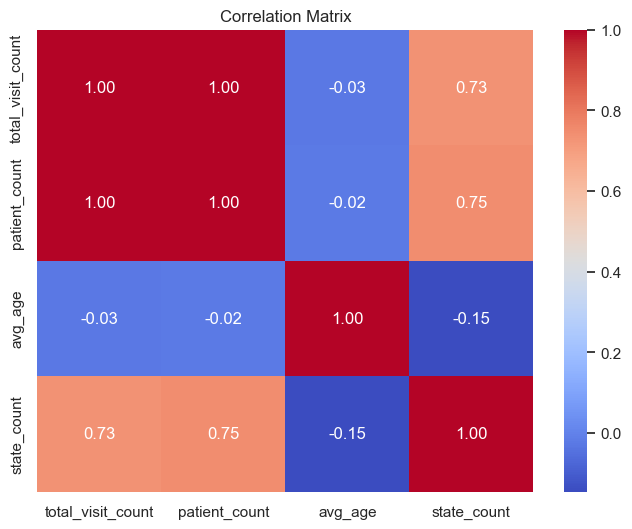

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
# Merge all features into one dataframe for correlation
correlation_df = pd.merge(institution_visit_counts, patient_count_per_institution, on='institution_id', how='left')
correlation_df = pd.merge(correlation_df, avg_age_per_institution, on='institution_id', how='left')
correlation_df = pd.merge(correlation_df, states_per_institution, on='institution_id', how='left')

# Display the first few rows of the correlation dataframe
print(correlation_df.head())

# Compute the correlation matrix
corr_matrix = correlation_df[['total_visit_count', 'patient_count', 'avg_age', 'state_count']].corr()

# Plot the correlation matrix using Seaborn's Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# sns.pairplot(correlation_df[['total_visit_count', 'patient_count', 'avg_age', 'state_count']], diag_kind='kde')
# plt.suptitle('Pairwise Relationships', y=1.02)
# plt.show()


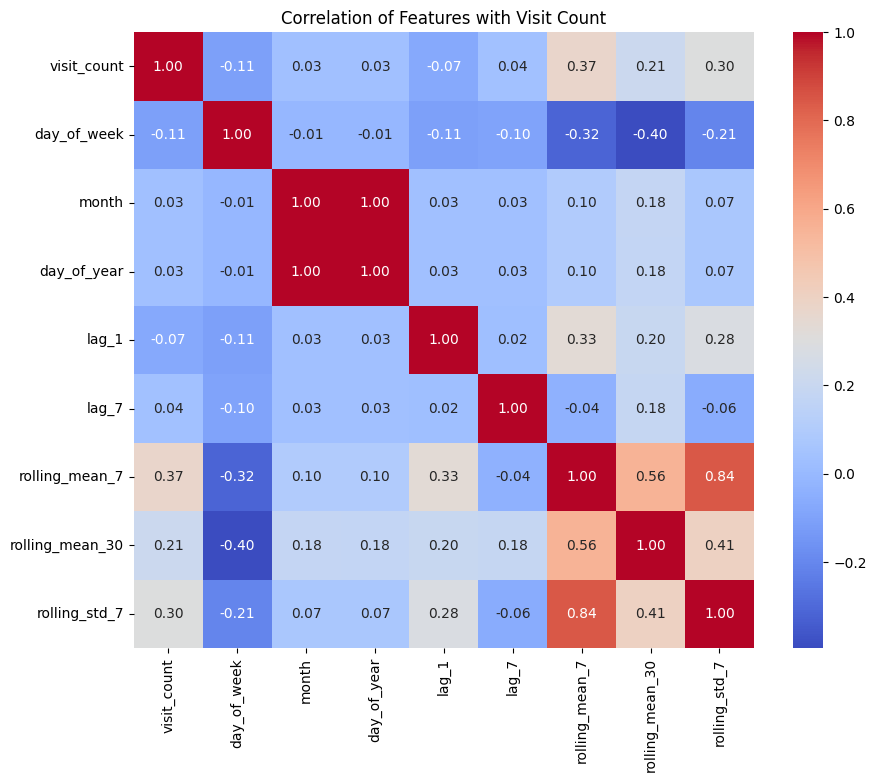

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert date columns to datetime
df_merged['inserted_at'] = pd.to_datetime(df_merged['inserted_at'])

# Aggregate visit data by date and institution_id
visit_data = (
    df_merged.groupby(['inserted_at', 'institution_id'])
    .size()
    .reset_index(name='visit_count')
)

# Feature Engineering: Add time-based and lag features
def create_features(df):
    df['day_of_week'] = df['inserted_at'].dt.dayofweek
    df['month'] = df['inserted_at'].dt.month
    df['day_of_year'] = df['inserted_at'].dt.dayofyear
    df['lag_1'] = df['visit_count'].shift(1)
    df['lag_7'] = df['visit_count'].shift(7)
    df['rolling_mean_7'] = df['visit_count'].rolling(window=7).mean()
    df['rolling_mean_30'] = df['visit_count'].rolling(window=30).mean()
    df['rolling_std_7'] = df['visit_count'].rolling(window=7).std()

    # Fill missing values created by shifting and rolling operations
    df.fillna(0, inplace=True)
    return df

# Apply the feature engineering function
visit_data = create_features(visit_data)

# Select only numeric columns for correlation analysis
numeric_features = visit_data[['visit_count', 'day_of_week', 'month', 'day_of_year', 'lag_1', 
                                'lag_7', 'rolling_mean_7', 'rolling_mean_30', 'rolling_std_7']]

# Compute the correlation matrix
corr_matrix = numeric_features.corr()

# Plot the correlation matrix using Seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Correlation of Features with Visit Count')
plt.show()

*Building SARIMAX Model*

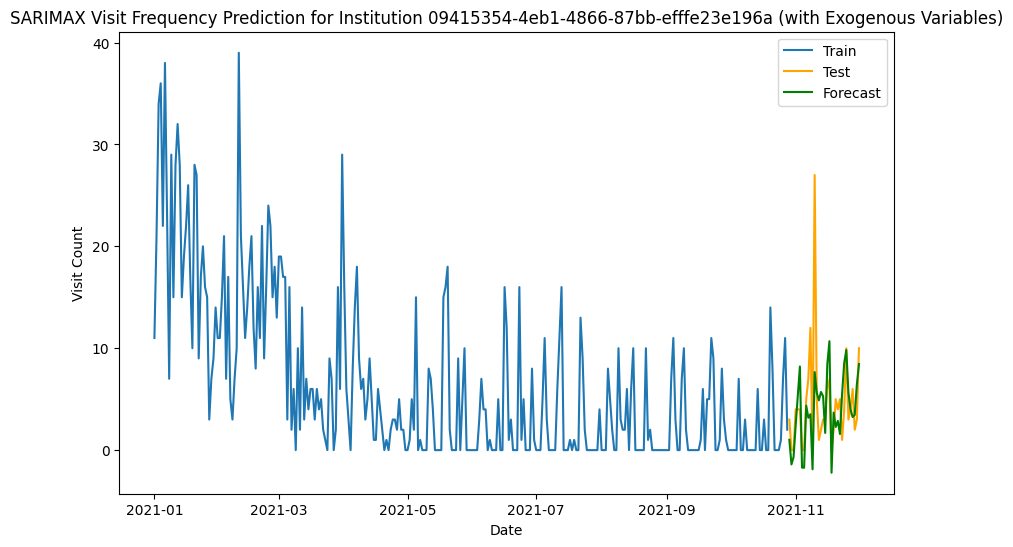

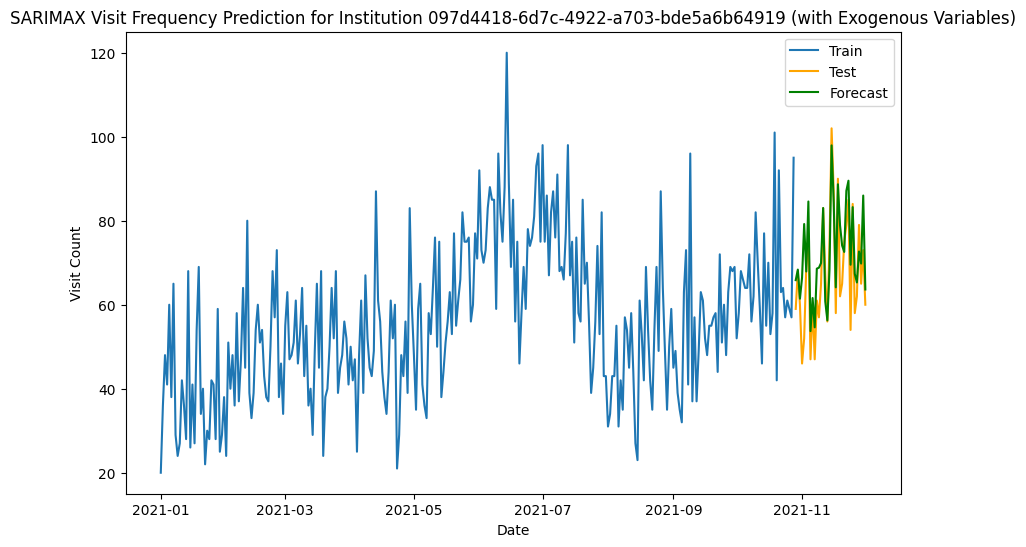

c:\Users\623783\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


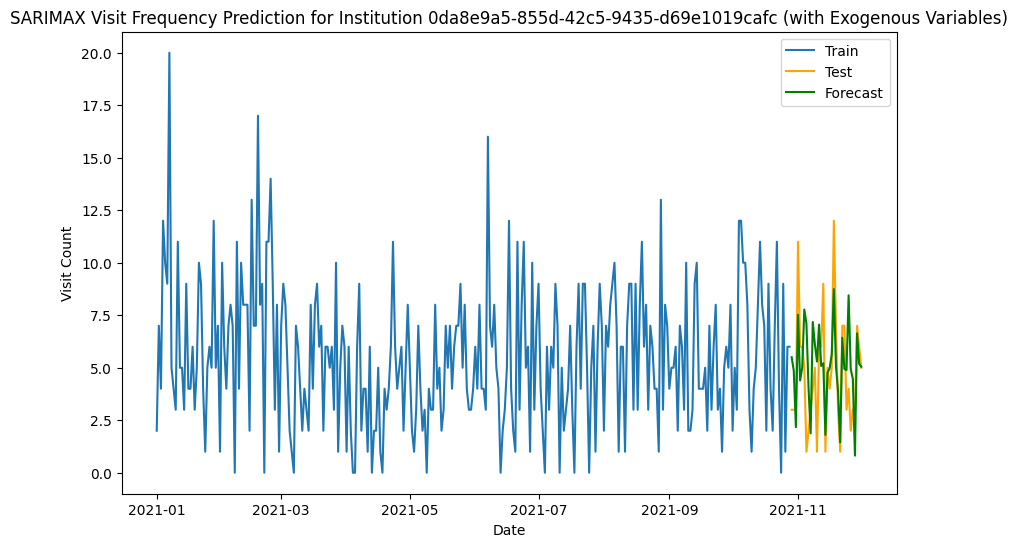

c:\Users\623783\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


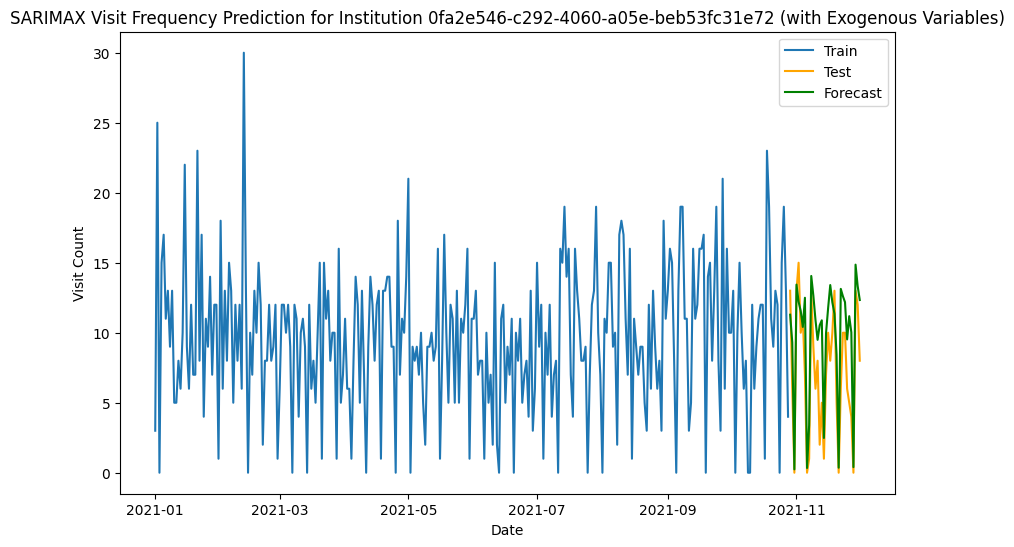

c:\Users\623783\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


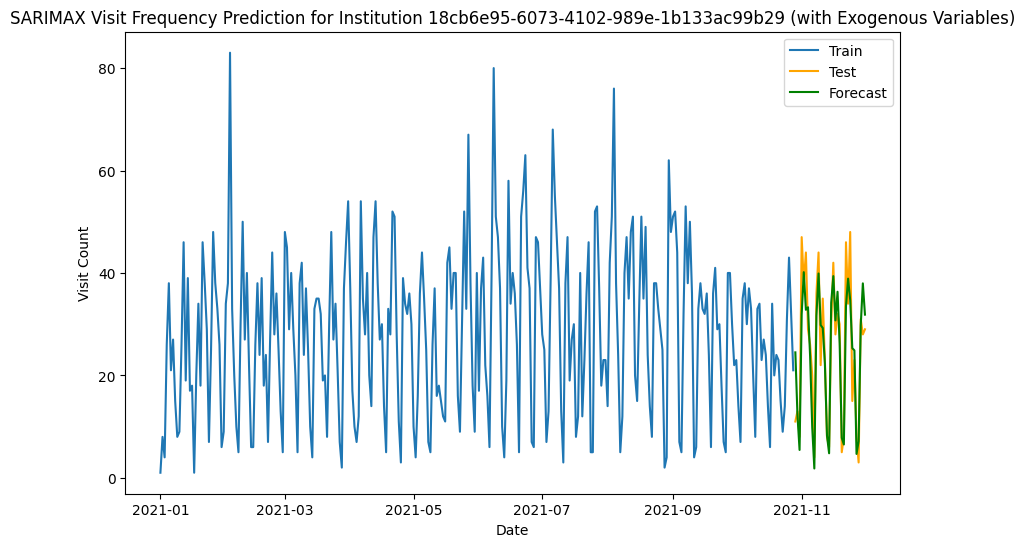

c:\Users\623783\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


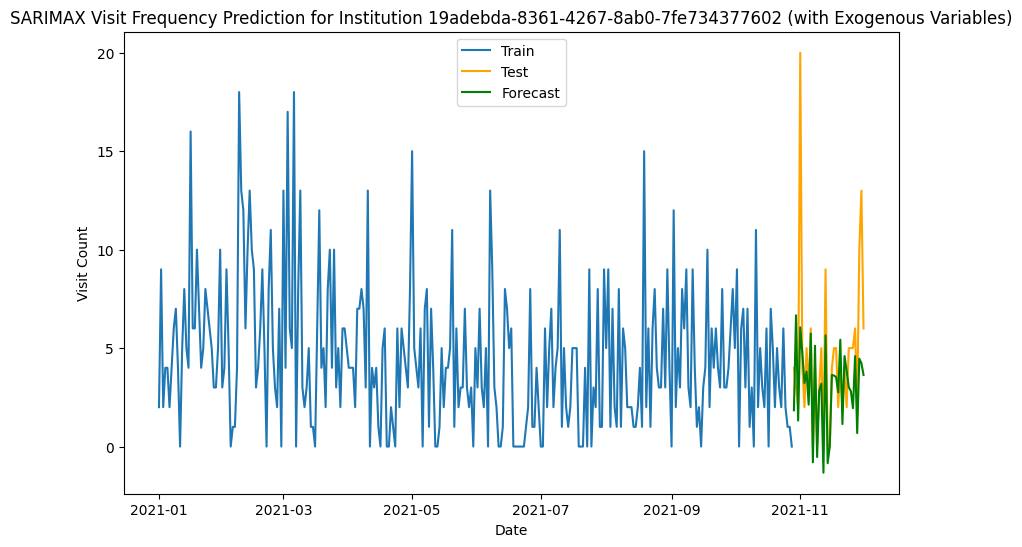

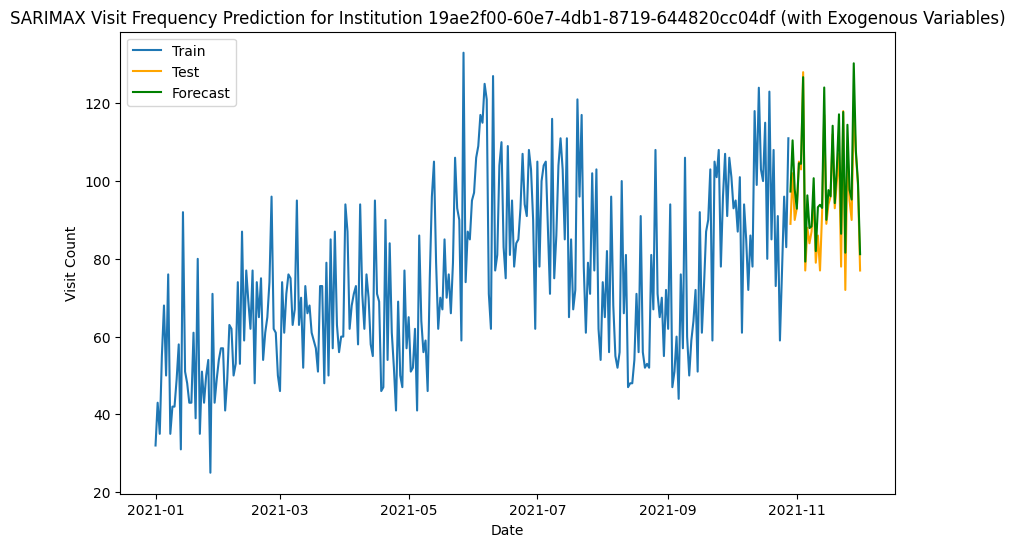

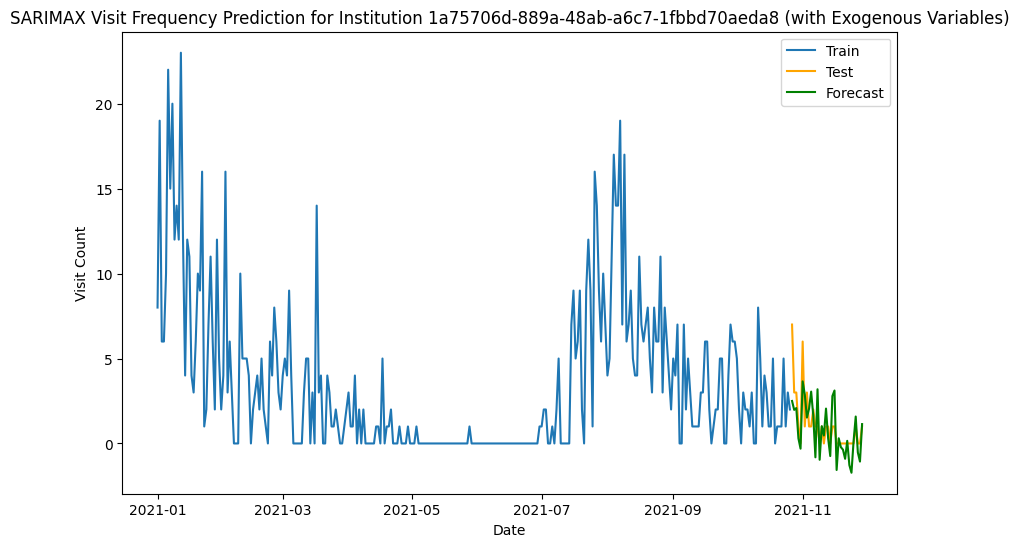

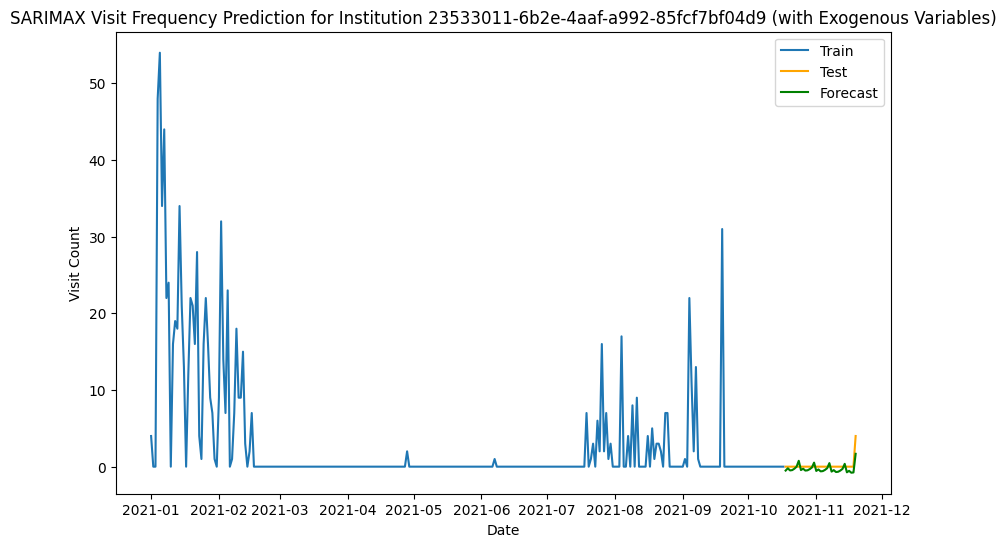

c:\Users\623783\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


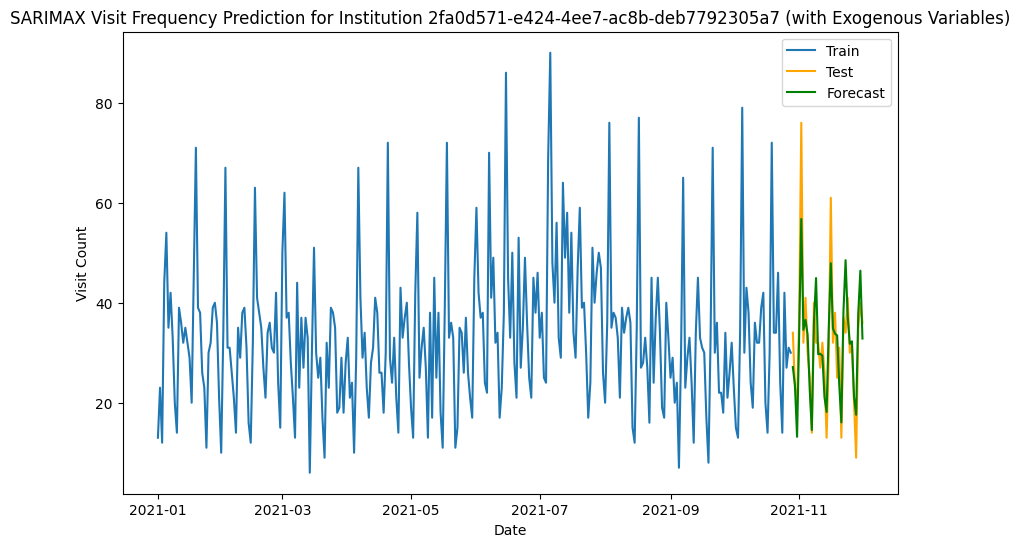

,Institution ID,MAE,RMSE
0,09415354-4eb1-4866-87bb-efffe23e196a,2.911506,4.403445
1,097d4418-6d7c-4922-a703-bde5a6b64919,6.747774,9.032736
2,0da8e9a5-855d-42c5-9435-d69e1019cafc,1.870326,2.326755
3,0fa2e546-c292-4060-a05e-beb53fc31e72,2.917434,3.618631
4,18cb6e95-6073-4102-989e-1b133ac99b29,5.133061,6.615361
5,19adebda-8361-4267-8ab0-7fe734377602,2.059718,3.355206
6,19ae2f00-60e7-4db1-8719-644820cc04df,4.575017,6.046701
7,1a75706d-889a-48ab-a6c7-1fbbd70aeda8,1.100790,1.418022
8,23533011-6b2e-4aaf-a992-85fcf7bf04d9,0.524366,0.641303
9,2fa0d571-e424-4ee7-ac8b-deb7792305a7,5.095736,6.647599


In [6]:
# Import libraries
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

# Convert dates to datetime 
df_merged['inserted_at'] = pd.to_datetime(df_merged['inserted_at'])
df_merged['state'] = df_merged['state'].str.title()  # Format state names

# Encode the 'type' column (hospital = 1, clinic = 0)
encoder = LabelEncoder()
df_merged['type_encoded'] = encoder.fit_transform(df_merged['type'])

# Calculate the unique count of patients (volume) per institution
patient_count_per_institution = (
    df_merged.groupby('institution_id')['patient_id']
    .nunique()
    .reset_index(name='patient_count')
)

# Calculate the number of states each institution is present in
states_per_institution = (
    df_merged.groupby('institution_id')['state']
    .nunique()
    .reset_index(name='state_count')
)

# Aggregate visit data by date and institution_id
visit_data = (
    df_merged.groupby(['inserted_at', 'institution_id'])
    .size()
    .reset_index(name='visit_count')
)

# Merge patient count and state count into the visit data
visit_data = pd.merge(visit_data, patient_count_per_institution, on='institution_id', how='left')
visit_data = pd.merge(visit_data, states_per_institution, on='institution_id', how='left')

avg_age_per_institution = (
    df_merged.groupby('institution_id')['age']
    .mean()
    .reset_index(name='avg_age')
)

# Merge average age into the visit data
visit_data = pd.merge(visit_data, avg_age_per_institution, on='institution_id', how='left')

# Merge encoded 'type' into the visit data
type_per_institution = df_merged[['institution_id', 'type_encoded']].drop_duplicates()
visit_data = pd.merge(visit_data, type_per_institution, on='institution_id', how='left')

# Feature Engineering: Create lag features, rolling averages, and other time-based features
def create_features(df):
    df['day_of_week'] = df['inserted_at'].dt.dayofweek
    df['rolling_mean_7'] = df['visit_count'].rolling(window=7).mean()
    df['rolling_mean_30'] = df['visit_count'].rolling(window=30).mean()
    df['rolling_std_7'] = df['visit_count'].rolling(window=7).std()

    # Fill missing values created by shifting and rolling operations
    df.fillna(0, inplace=True)
    return df

visit_data = create_features(visit_data)

# Apply StandardScaler to scale features
scaler = StandardScaler()

# List of features to scale (excluding the target variable)
features_to_scale = ['day_of_week', 'rolling_mean_7', 'rolling_mean_30', 'rolling_std_7', 
                     'state_count', 'avg_age', 'type_encoded']

# Scale the features
visit_data[features_to_scale] = scaler.fit_transform(visit_data[features_to_scale])

# Function to train and forecast SARIMAX with error metrics (MAE, RMSE, R^2)
def forecast_and_evaluate(institution_id):
    # Filter data for the institution
    institution_data = visit_data[visit_data['institution_id'] == institution_id].copy()

    # Set the index to the time column
    institution_data = institution_data.set_index('inserted_at').asfreq('D').fillna(0)

    # Define endogenous (target) variable (visit_count)
    endog = institution_data['visit_count']

    # Define exogenous variables (scaled features including 'type_encoded')
    exog = institution_data[['day_of_week', 'rolling_mean_7', 'rolling_mean_30', 'rolling_std_7',
                             'state_count', 'avg_age', 'type_encoded']]

    # Split into train and test sets (90% train, 10% test)
    train_size = int(len(endog) * 0.9)
    train_endog, test_endog = endog[:train_size], endog[train_size:]
    train_exog, test_exog = exog[:train_size], exog[train_size:]

    # Fit the SARIMAX model with exogenous variables
    model = SARIMAX(train_endog, exog=train_exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
    model_fit = model.fit(disp=False)

    # Forecast the future visits
    forecast = model_fit.forecast(steps=len(test_endog), exog=test_exog)

    # Evaluate the model
    mae = mean_absolute_error(test_endog, forecast)
    rmse = np.sqrt(mean_squared_error(test_endog, forecast))

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(train_endog, label='Train')
    plt.plot(test_endog, label='Test', color='orange')
    plt.plot(forecast, label='Forecast', color='green')
    plt.title(f'SARIMAX Visit Frequency Prediction for Institution {institution_id} (with Exogenous Variables)')
    plt.xlabel('Date')
    plt.ylabel('Visit Count')
    plt.legend()
    plt.show()

    return mae, rmse

# Create a DataFrame to store evaluation results for the first 10 institutions
evaluation_results = []

for institution_id in visit_data['institution_id'].unique()[:10]:
    mae, rmse = forecast_and_evaluate(institution_id)
    evaluation_results.append({
        'Institution ID': institution_id,
        'MAE': mae,
        'RMSE': rmse
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(evaluation_results)

# Display the results
results_df.to_csv("SARIMAX_Metrics.csv", index=False)
results_df


In [7]:
admissions_per_institution = (
    df_merged.groupby('institution_id')['admitted_at']
    .count()
    .reset_index(name='admissions_count')
)



In [8]:
resource_data = pd.merge(visit_data, admissions_per_institution, on='institution_id', how='left')
# resource_data['available_resources'] = ...  # Add available resources manually or from data
# resource_data['distance_factor'] = ...  # Compute distances between institutions if required

In [50]:
resource_data

,inserted_at,institution_id,visit_count,patient_count,state_count,avg_age,type_encoded,day_of_week,rolling_mean_7,rolling_mean_30,rolling_std_7,admissions_count
0,2021-01-01,097d4418-6d7c-4922-a703-bde5a6b64919,1,225,0.380917,-2.539774,0.15808,0.629470,-2.814587,-5.407939,-1.127561,254
1,2021-01-01,384b1f28-514a-4a8f-8cc2-f5b2f94d7d09,7,476,-0.245658,-0.484752,0.15808,0.629470,-2.814587,-5.407939,-1.127561,610
2,2021-01-01,3bbbf782-497c-4697-abda-0a88bbee1b38,3,1472,0.494839,0.101207,0.15808,0.629470,-2.814587,-5.407939,-1.127561,1738
3,2021-01-01,46412e2a-6b5f-4d0c-9562-d89c01d15259,1,76,-0.815271,1.559758,0.15808,0.629470,-2.814587,-5.407939,-1.127561,92
4,2021-01-01,5ee1f2ed-2622-4012-8c2f-aca9f5c1af3f,4,495,-0.701348,-0.322084,0.15808,0.629470,-2.814587,-5.407939,-1.127561,592
...,...,...,...,...,...,...,...,...,...,...,...,...
7091,2021-12-01,d9f64a07-9c47-4f6e-8bbe-a473a688a735,2,1748,4.425169,1.746833,0.15808,-0.397834,-0.846135,-0.098517,-0.751876,1867
7092,2021-12-01,e2adc287-86ec-4341-b43d-13cb91255662,1,164,-0.815271,0.363433,0.15808,-0.397834,-1.042980,-0.098517,-0.784609,192
7093,2021-12-01,e81b1231-55bc-488a-abf3-9bf0883430ba,1,75,-0.017812,0.042832,0.15808,-0.397834,-1.042980,-0.098517,-0.784609,80
7094,2021-12-01,ece0641a-2b44-4cb1-8e31-074dd5fbb4f1,2,254,-0.017812,-0.346592,0.15808,-0.397834,-1.042980,-0.010026,-0.784609,308


In [ ]:
# Resource Allocation.
from pulp import LpProblem, LpVariable, lpSum, LpMinimize
import pandas as pd

# Initialize a list to store forecast results
forecast_results = []

# Process only the first 10 unique institution IDs
forecast_results = []

for institution_id in visit_data['institution_id'].unique()[:10]:
    # Filter data for the institution
    institution_data = visit_data[visit_data['institution_id'] == institution_id].copy()
    institution_data = institution_data.set_index('inserted_at').asfreq('D').fillna(0)

    # Endogenous and exogenous variables
    endog = institution_data['visit_count']
    exog = institution_data[['day_of_week', 'rolling_mean_7', 'rolling_mean_30', 'rolling_std_7',
                             'state_count', 'avg_age', 'type_encoded']]

    # Split into train and test
    train_size = int(len(endog) * 0.9)
    train_endog, test_endog = endog[:train_size], endog[train_size:]
    train_exog, test_exog = exog[:train_size], exog[train_size:]

    # Fit SARIMAX model
    model = SARIMAX(train_endog, exog=train_exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
    model_fit = model.fit(disp=False)

    # Forecast future visits
    forecast = model_fit.forecast(steps=len(test_endog), exog=test_exog)

    # Append results to forecast_results
    forecast_results.append({
        'institution_id': institution_id,
        'forecasted_visit_count': forecast.sum()  # Sum of forecasted values or modify as needed
    })

forecast_df = pd.DataFrame(forecast_results)

# Convert forecast results into a DataFrame
forecast_df = pd.DataFrame(forecast_results)

# Ensure 'institution_id' has the same data type in both DataFrames
forecast_df['institution_id'] = forecast_df['institution_id'].astype(str)
resource_data['institution_id'] = resource_data['institution_id'].astype(str)

# Merge forecasted visit counts with resource data
resource_data = pd.merge(forecast_df, resource_data, on='institution_id', how='inner')


# Total available bed space
total_bedspace = 3000

# Create the optimization problem
problem = LpProblem("Resource_Allocation_Baseline", LpMinimize)

# Define decision variables: resources allocated to each institution
resource_vars = {
    inst_id: LpVariable(f"resources_{inst_id}", lowBound=0)
    for inst_id in forecast_df['institution_id'].unique()
}

# Create a dictionary for the auxiliary variables (absolute differences)
abs_diff_vars = {
    inst_id: LpVariable(f"abs_diff_{inst_id}", lowBound=0)
    for inst_id in resource_vars.keys()
}

# Objective: Minimize the absolute difference between allocated resources and forecasted demand
problem += lpSum([
    abs_diff_vars[inst_id]  # Minimize the absolute differences
    for inst_id in resource_vars.keys()
])

# Constraints: Link the absolute difference variables to the actual differences
for inst_id in resource_vars.keys():
    forecasted_demand = resource_data.loc[resource_data['institution_id'] == inst_id, 'forecasted_visit_count'].values[0]
    # Create two constraints to model the absolute difference
    problem += abs_diff_vars[inst_id] >= resource_vars[inst_id] - forecasted_demand  # |x - forecasted_demand|
    problem += abs_diff_vars[inst_id] >= forecasted_demand - resource_vars[inst_id]  # |forecasted_demand - x|

# Constraints (e.g., resource limits, other conditions)
for inst_id in resource_vars.keys():
    institution_data = resource_data[resource_data['institution_id'] == inst_id]
    
    # Ensure allocated resources are proportional to historical patient volume
    patient_capacity = institution_data['patient_count'].values[0]
    problem += resource_vars[inst_id] <= patient_capacity * 1.2  # Allow up to 120% of historical capacity
    
    # Allocate resources proportionally to the number of states served
    state_weight = institution_data['state_count'].values[0]
    problem += resource_vars[inst_id] <= state_weight * 100  # Scale state presence to a reasonable range
    
    # Ensure no institution is allocated zero resources
    forecasted_demand = institution_data['forecasted_visit_count'].values[0]
    problem += resource_vars[inst_id] >= forecasted_demand * 0.8  # At least 80% of predicted demand

# Total bed space constraint
problem += lpSum(resource_vars.values()) <= total_bedspace

# Solve the optimization problem
problem.solve()

# Extract results
allocation_results = {
    inst_id: resource_vars[inst_id].varValue
    for inst_id in resource_vars.keys()
}

# Create a DataFrame for results
allocation_df = pd.DataFrame([{
    "Institution ID": inst_id,
    "Forecasted Demand": resource_data.loc[resource_data['institution_id'] == inst_id, 'forecasted_visit_count'].values[0],
    "Allocated Resources": allocation_results[inst_id]
} for inst_id in resource_vars.keys()])

# Save results to a CSV
allocation_df.to_csv("Resource_Allocation_Results.csv", index=False)

# Display results
print(allocation_df)

'''
The accuracy of the model can be improved if some exisitng infrasture data is available.
'''

c:\Users\623783\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\623783\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\623783\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\623783\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\623783\AppData\Local\anaconda3\

                         Institution ID  Forecasted Demand  \
0  09415354-4eb1-4866-87bb-efffe23e196a         133.902141   
1  097d4418-6d7c-4922-a703-bde5a6b64919        2454.278416   
2  0da8e9a5-855d-42c5-9435-d69e1019cafc         174.289911   
3  0fa2e546-c292-4060-a05e-beb53fc31e72         332.728611   
4  18cb6e95-6073-4102-989e-1b133ac99b29         831.838154   
5  19adebda-8361-4267-8ab0-7fe734377602         102.710587   
6  19ae2f00-60e7-4db1-8719-644820cc04df        3398.441081   
7  1a75706d-889a-48ab-a6c7-1fbbd70aeda8          27.456487   
8  23533011-6b2e-4aaf-a992-85fcf7bf04d9          -9.057491   
9  2fa0d571-e424-4ee7-ac8b-deb7792305a7        1073.784075   

   Allocated Resources  
0              0.00000  
1           2454.27840  
2              0.00000  
3              0.00000  
4              0.00000  
5              0.00000  
6            235.03874  
7              0.00000  
8              0.00000  
9              0.00000  


*Xgboost*

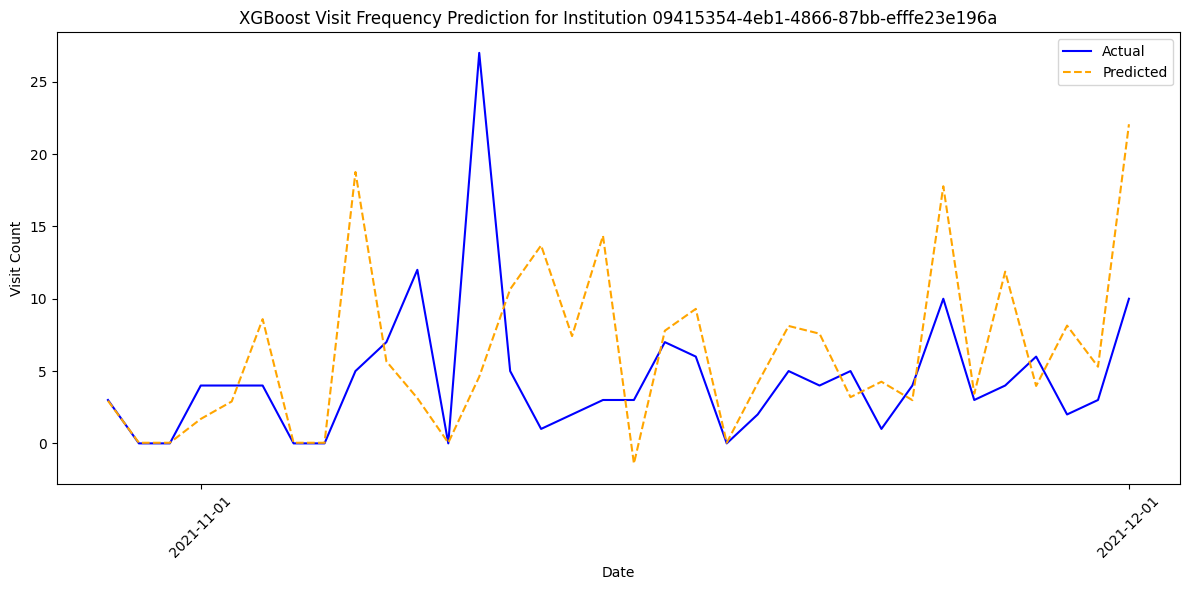

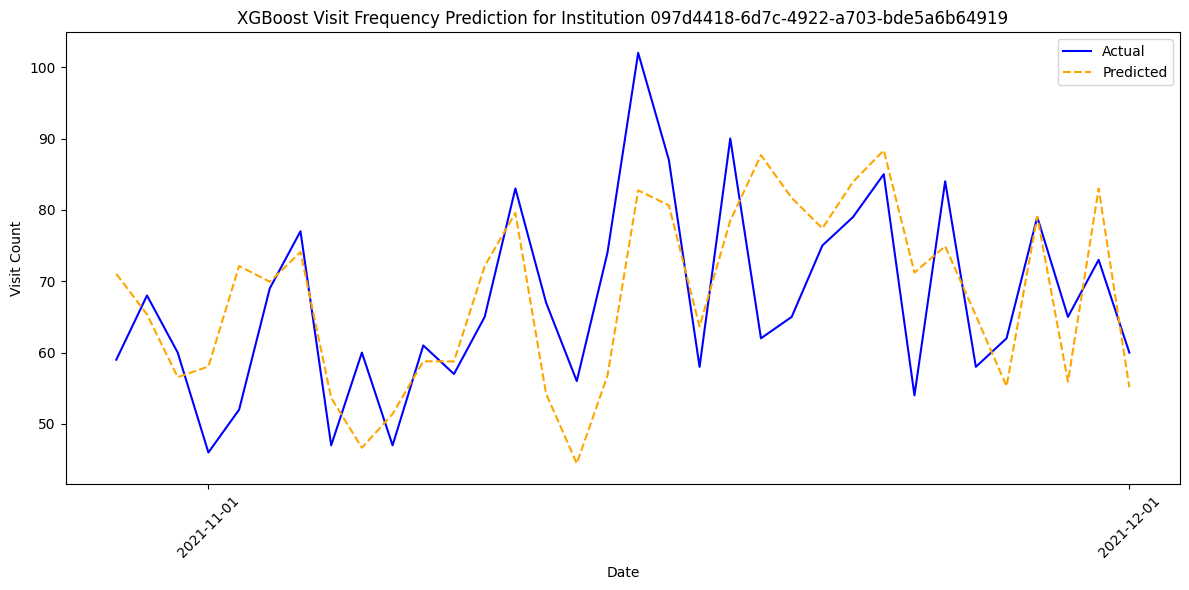

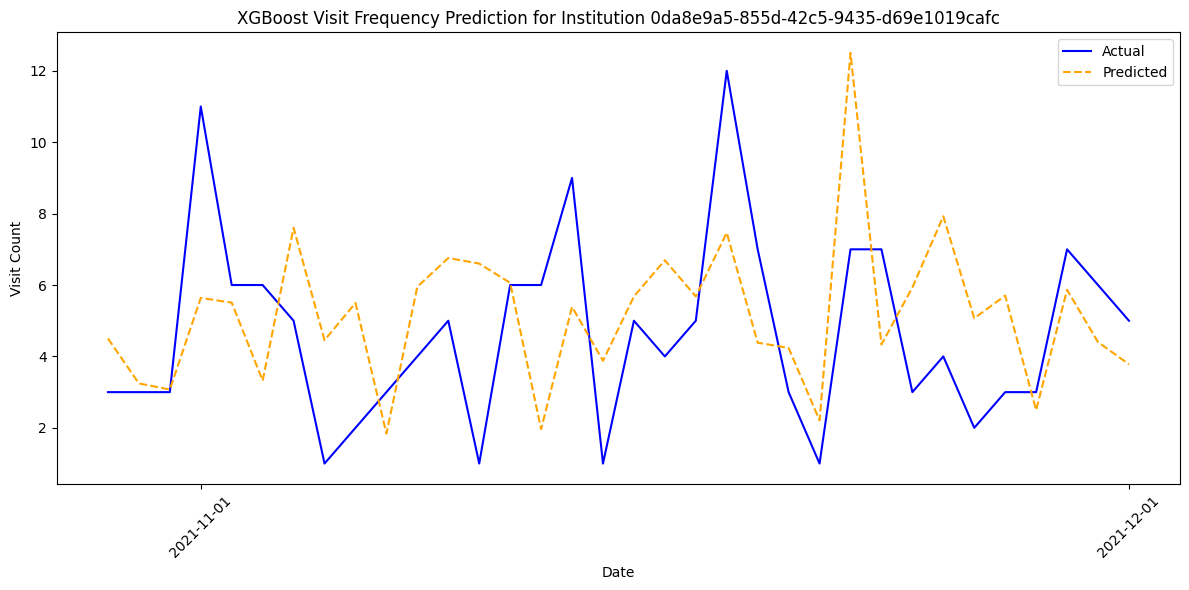

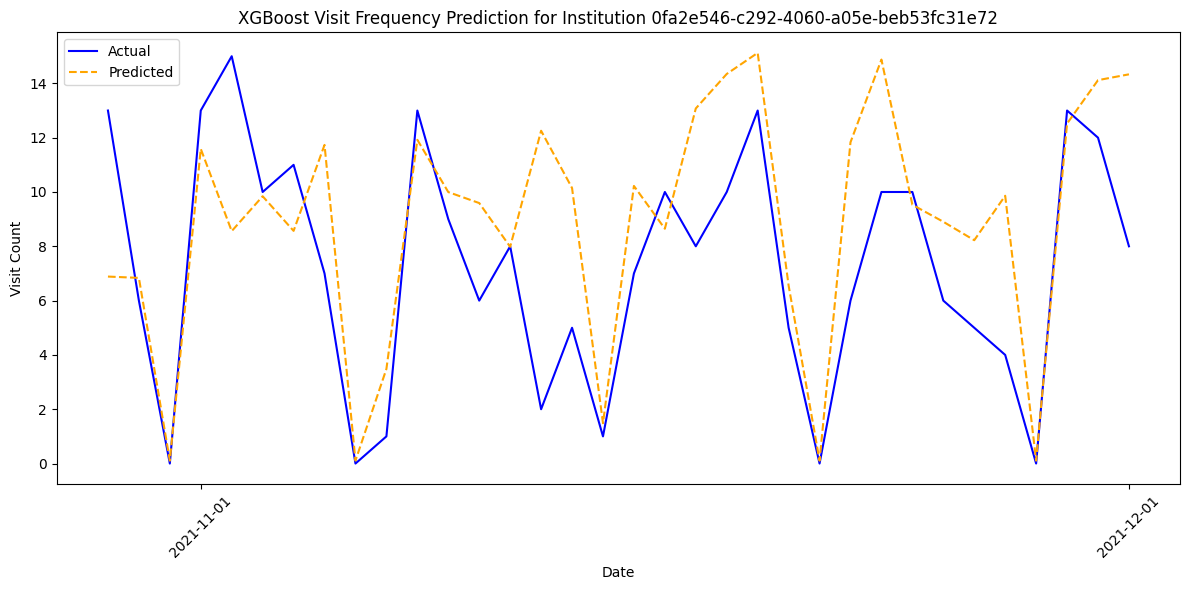

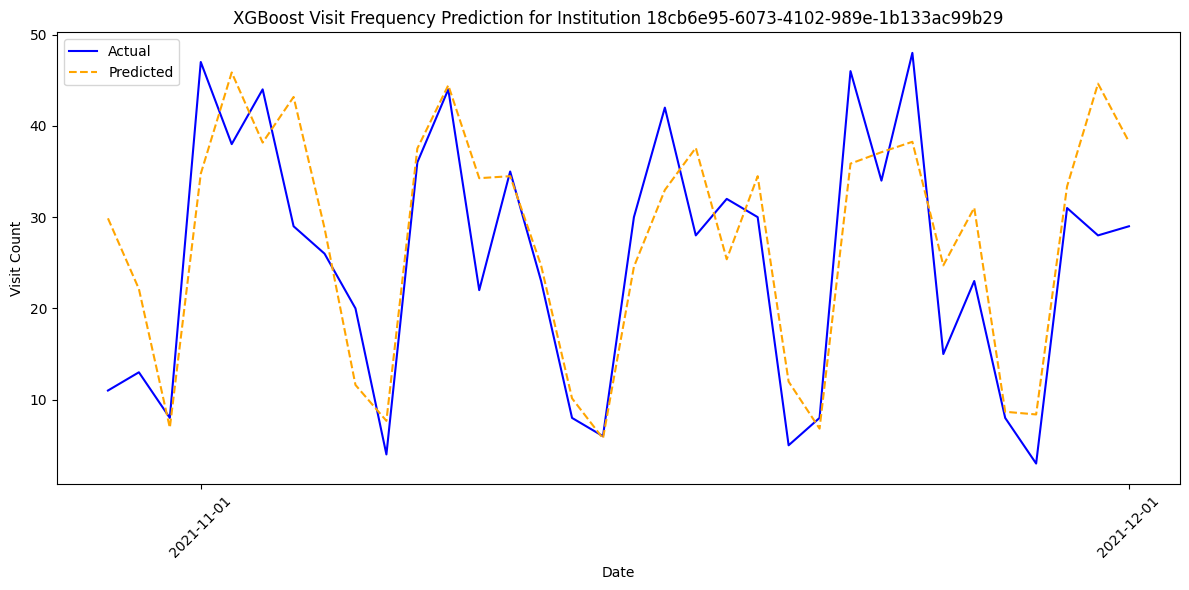

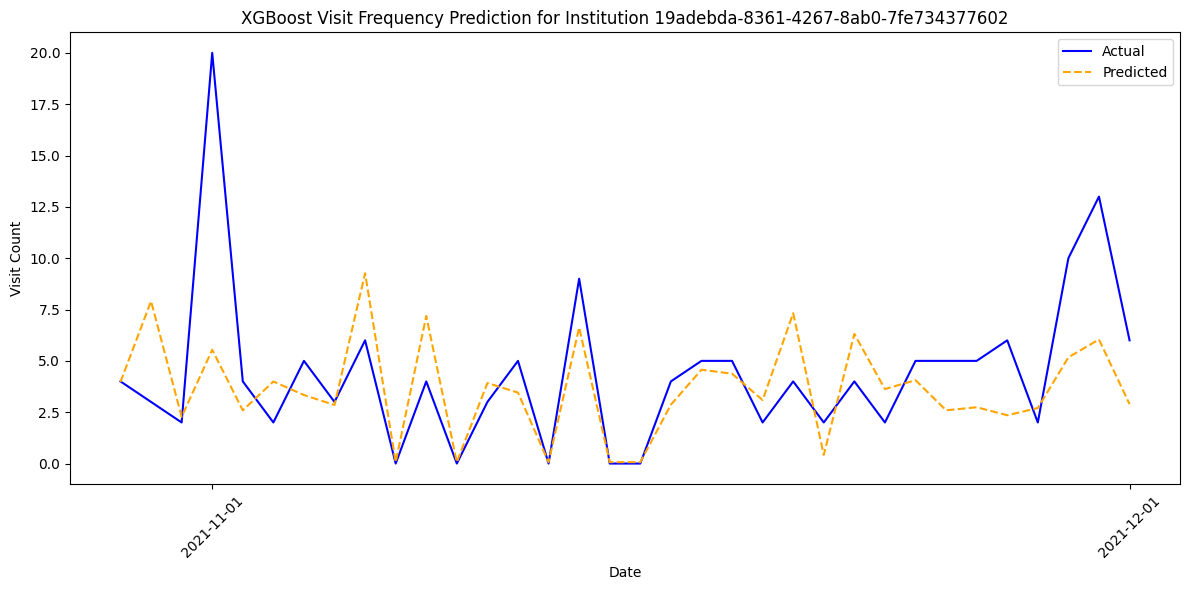

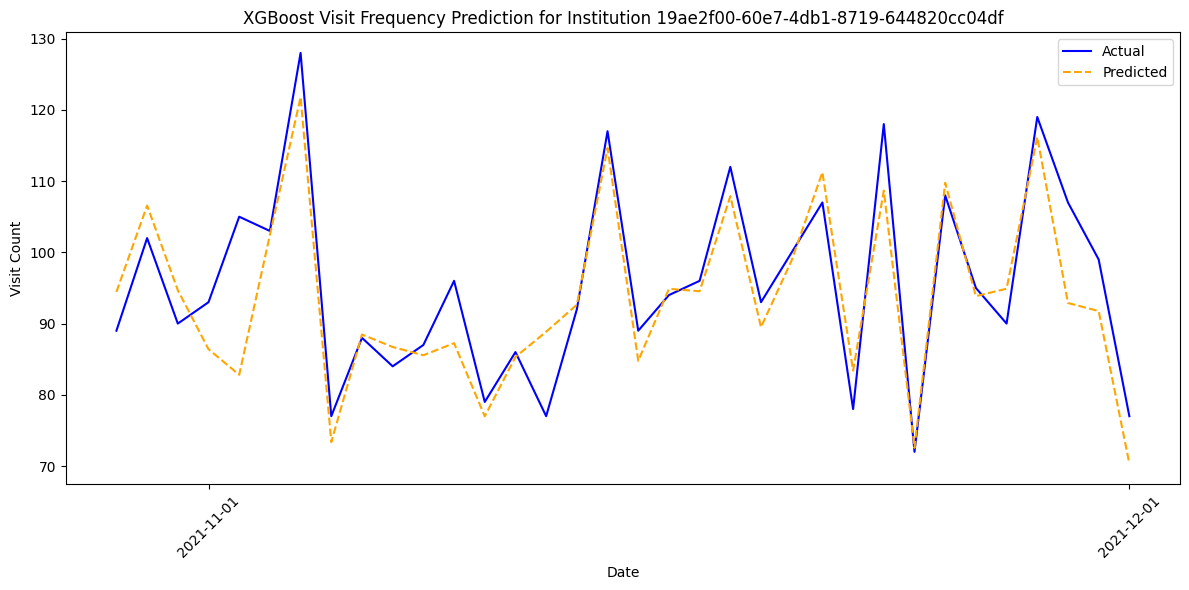

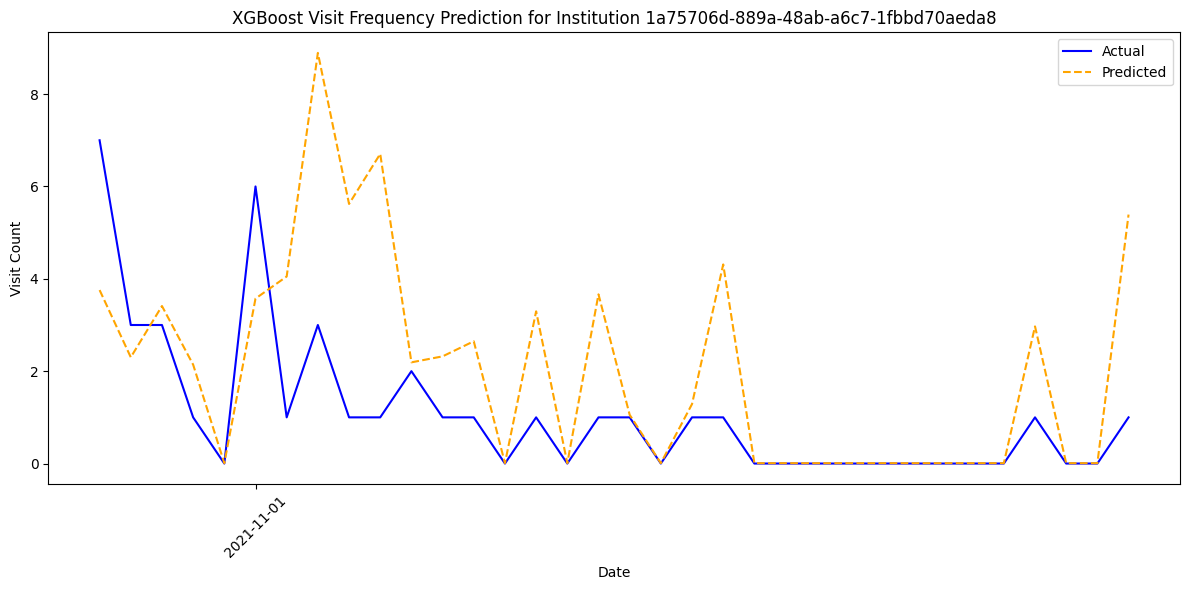

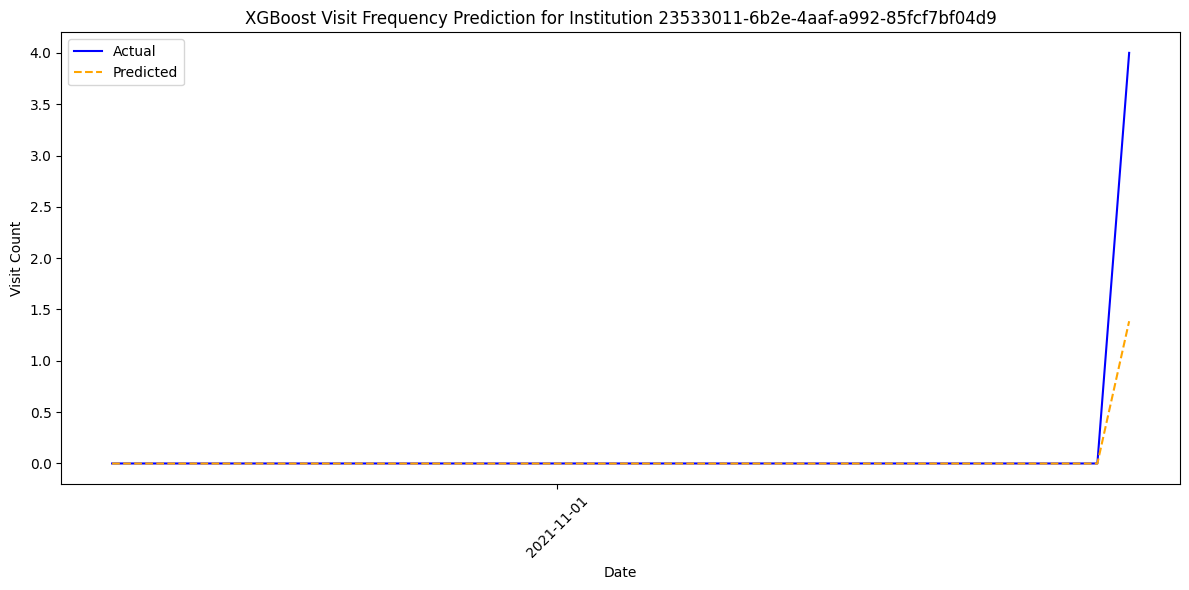

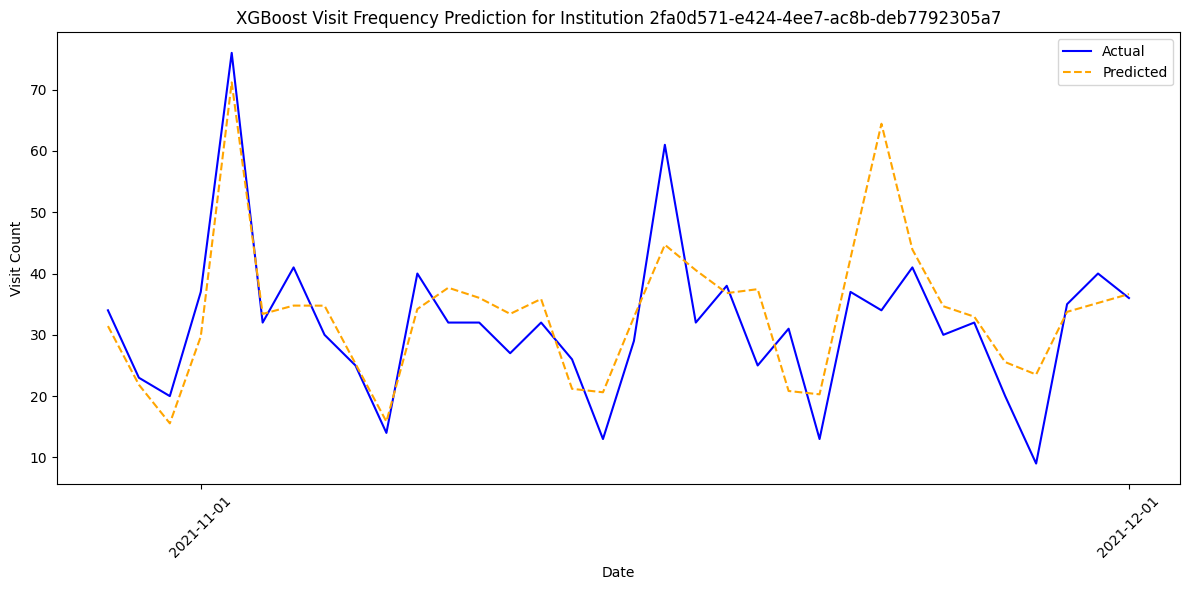

,Institution ID,MAE,RMSE
0,09415354-4eb1-4866-87bb-efffe23e196a,4.465753,6.727296
1,097d4418-6d7c-4922-a703-bde5a6b64919,8.664539,10.660311
2,0da8e9a5-855d-42c5-9435-d69e1019cafc,2.348906,2.812373
3,0fa2e546-c292-4060-a05e-beb53fc31e72,2.835082,3.768774
4,18cb6e95-6073-4102-989e-1b133ac99b29,6.507390,8.080336
5,19adebda-8361-4267-8ab0-7fe734377602,2.161287,3.443570
6,19ae2f00-60e7-4db1-8719-644820cc04df,4.654722,6.452037
7,1a75706d-889a-48ab-a6c7-1fbbd70aeda8,1.336590,2.218859
8,23533011-6b2e-4aaf-a992-85fcf7bf04d9,0.079900,0.455083
9,2fa0d571-e424-4ee7-ac8b-deb7792305a7,6.002909,8.245859


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
import xgboost as xgb
import matplotlib.dates as mdates

# Convert dates to datetime and merge on both patient_id and institution_id
df_merged['inserted_at'] = pd.to_datetime(df_merged['inserted_at'])
df_merged['dob'] = pd.to_datetime(df_merged['dob'])
df_merged['state'] = df_merged['state'].str.title()

# Encode 'type' column
encoder = LabelEncoder()
df_merged['type_encoded'] = encoder.fit_transform(df_merged['type'])

# Calculate patient count and state count
patient_count_per_institution = (
    df_merged.groupby('institution_id')['patient_id']
    .nunique()
    .reset_index(name='patient_count')
)
states_per_institution = (
    df_merged.groupby('institution_id')['state']
    .nunique()
    .reset_index(name='state_count')
)

# Aggregate visit data
visit_data = (
    df_merged.groupby(['inserted_at', 'institution_id'])
    .size()
    .reset_index(name='visit_count')
)

# Merge aggregated features
visit_data = pd.merge(visit_data, patient_count_per_institution, on='institution_id', how='left')
visit_data = pd.merge(visit_data, states_per_institution, on='institution_id', how='left')

avg_age_per_institution = (
    df_merged.groupby('institution_id')['age']
    .mean()
    .reset_index(name='avg_age')
)
visit_data = pd.merge(visit_data, avg_age_per_institution, on='institution_id', how='left')
visit_data = pd.merge(visit_data, df_merged[['institution_id', 'type_encoded']].drop_duplicates(), on='institution_id', how='left')

# Feature engineering
def create_features(df):
    df['day_of_week'] = df['inserted_at'].dt.dayofweek
    df['rolling_mean_7'] = df['visit_count'].rolling(window=7).mean()
    df['rolling_mean_30'] = df['visit_count'].rolling(window=30).mean()
    df['rolling_std_7'] = df['visit_count'].rolling(window=7).std()
    df.fillna(0, inplace=True)
    return df

visit_data = create_features(visit_data)

# Scaling features
scaler = StandardScaler()
features_to_scale = ['day_of_week', 'rolling_mean_7', 'rolling_mean_30', 'rolling_std_7', 'state_count', 'avg_age', 'type_encoded']
visit_data[features_to_scale] = scaler.fit_transform(visit_data[features_to_scale])

# XGBoost Model
def train_xgboost(institution_id):
    # Filter data for the institution
    institution_data = visit_data[visit_data['institution_id'] == institution_id].copy()
    institution_data = institution_data.set_index('inserted_at').asfreq('D').fillna(0)
    
    # Define target and features
    target = institution_data['visit_count']
    features = institution_data[['day_of_week', 'rolling_mean_7', 'rolling_mean_30', 'rolling_std_7', 
                                 'state_count', 'avg_age', 'type_encoded']]
    
    # Train-test split
    train_size = int(len(target) * 0.9)
    train_X, train_y = features[:train_size], target[:train_size]
    test_X, test_y = features[train_size:], target[train_size:]
    
    # Train XGBoost
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
    model.fit(train_X, train_y)
    
    # Predictions
    predictions = model.predict(test_X)
    
    # Evaluation metrics
    mae = mean_absolute_error(test_y, predictions)
    rmse = np.sqrt(mean_squared_error(test_y, predictions))
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(test_y.index, test_y, label='Actual', color='blue', linewidth=1.5)
    plt.plot(test_y.index, predictions, label='Predicted', color='orange', linestyle='--', linewidth=1.5)
    plt.title(f'XGBoost Visit Frequency Prediction for Institution {institution_id}')
    plt.xlabel('Date')
    plt.ylabel('Visit Count')
    plt.legend()

# Format the x-axis dates
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format as 'YYYY-MM-DD'
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Show one tick per month
    plt.xticks(rotation=45)  # Rotate the x-axis labels for readability

    plt.tight_layout()  # Adjust the layout to prevent overlap
    plt.show()
    
    return mae, rmse

# Evaluate the model for the first 10 institutions
results = []
for institution_id in visit_data['institution_id'].unique()[:10]:
    mae, rmse = train_xgboost(institution_id)
    results.append({'Institution ID': institution_id, 'MAE': mae, 'RMSE': rmse})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
#Save result
results_df.to_csv("Xgboost_Metrics.csv", index=False)
# Display results
results_df


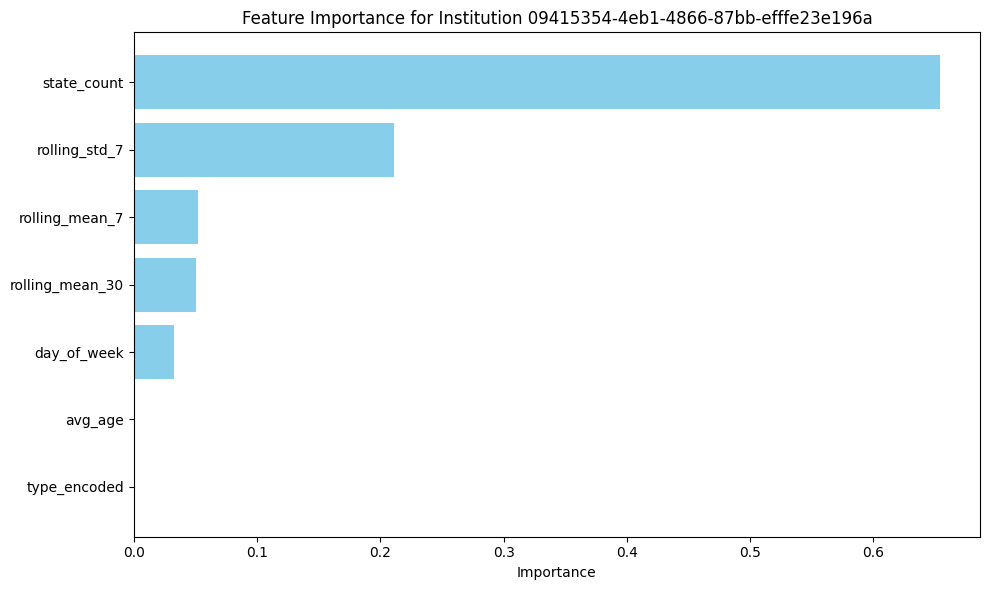

Feature Importance for Institution 09415354-4eb1-4866-87bb-efffe23e196a
           Feature  Importance
4      state_count    0.653857
3    rolling_std_7    0.210930
1   rolling_mean_7    0.051746
2  rolling_mean_30    0.050566
0      day_of_week    0.032901
5          avg_age    0.000000
6     type_encoded    0.000000


In [45]:
# Modify the train_xgboost function to include feature importance analysis
def train_xgboost_with_importance(institution_id):
    # Filter data for the institution
    institution_data = visit_data[visit_data['institution_id'] == institution_id].copy()
    institution_data = institution_data.set_index('inserted_at').asfreq('D').fillna(0)
    
    # Define target and features
    target = institution_data['visit_count']
    features = institution_data[['day_of_week', 'rolling_mean_7', 'rolling_mean_30', 'rolling_std_7', 
                                 'state_count', 'avg_age', 'type_encoded']]
    
    # Train-test split
    train_size = int(len(target) * 0.9)
    train_X, train_y = features[:train_size], target[:train_size]
    test_X, test_y = features[train_size:], target[train_size:]
    
    # Train XGBoost
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
    model.fit(train_X, train_y)
    
    # Predictions
    predictions = model.predict(test_X)
    
    # Evaluation metrics
    mae = mean_absolute_error(test_y, predictions)
    rmse = np.sqrt(mean_squared_error(test_y, predictions))
    

    # Feature importance
    importance = model.feature_importances_
    feature_names = features.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    importance_df.sort_values(by='Importance', ascending=False, inplace=True)
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title(f'Feature Importance for Institution {institution_id}')
    plt.gca().invert_yaxis()  # Invert y-axis to show highest importance at the top
    plt.tight_layout()
    plt.show()
    
    return mae, rmse, importance_df

# Evaluate the model for the first institution and display feature importance
institution_id = visit_data['institution_id'].unique()[0]
mae, rmse, importance_df = train_xgboost_with_importance(institution_id)

# Save feature importance
importance_df.to_csv(f"Feature_Importance_Institution_{institution_id}.csv", index=False)
print(f"Feature Importance for Institution {institution_id}")
print(importance_df)
